In [100]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import os

# Trabalho 1 de Introdução a computação visual
Nosso trabalho consiste da implementação de um método de compressão baseado no JPEG.
O seguinte método foi utilizado:


1.   Codificação por transformada de cossenos
2.   Quantização
3. Ordenação zigue-zague
4. Codificação por RLE e Huffman




#Tabelas Huffman
Como artifício para gerar uma melhor compressão, utilizamos tabelas Huffman padronizadas. Apesar de não serem feitas com base na distribuição de probabilidades de cada imagem, elas não precisam ser armazenadas junto da imagem comprimida. Ambas tabelas utilizadas foram achadas no site [w3.org](https://w3.org) e estão definidas como:

[INTERNATIONAL TELECOMMUNICATION UNION

TERMINAL EQUIPMENT AND PROTOCOLS
FOR TELEMATIC SERVICES

INFORMATION TECHNOLOGY –
DIGITAL COMPRESSION AND CODING
OF CONTINUOUS-TONE STILL IMAGES –
REQUIREMENTS AND GUIDELINES] (https://www.w3.org/Graphics/JPEG/itu-t81.pdf)

# Tabela Huffman para coeficientes DC
- O index corresponde ao número de bits para representar o coeficiente DC
- Em seguida temos os valores x e y no dicionário, sendo que x representa o número de bits necessário para representar o código huffman e y representa o próprio código.

In [101]:
STEP = 8 # tamanho do bloco a ser analisado
QUALITY_FACTOR = float(40/6)

DC_COEF = {"0": ["2", "00"],
           "1": ["3", "010"],
           "2": ["3", "011"],
           "3": ["3", "100"],
           "4": ["3", "101"],
           "5": ["3", "110"],
           "6": ["4", "1110"],
           "7": ["5", "11110"],
           "8": ["6", "111110"],
           "9": ["7", "1111110"],
           "10": ["8", "11111110"],
           "11": ["9", "111111110"]}

DC_ILUMINANCE_TABLE = pd.DataFrame.from_dict(DC_COEF, orient='index')
DC_ILUMINANCE_TABLE.columns = ["CodeLength", "Code"]

# Tabela Huffman para coeficientes AC
- O index corresponde a tupla (x,y), x sendo o número de 0 que precede o número, y sendo o número de bits necessários para representar o número.
- Em seguida temos os valores x e y no dicionário, sendo que x representa o número de bits necessários para representar o código huffman e y representa o próprio código.

In [102]:


ILUMINANCE_COEF = { "0,0": ["4", "1010"],
 "0,2": ["2", "01"],
 "0,1": ["2", "00"], "0,3": ["3", "100"], "0,4": ["4", "1011"],
 "0,5": ["5", "11010"], "0,6": ["7", "1111000"], "0,7": ["8", "11111000"], "0,8": ["10", "1111110110"],
 "0,9": ["16", "1111111110000010"], "0,10": ["16", "1111111110000011"], "1,1": ["4", "1100"], "1,2": ["5", "11011"],
 "1,3": ["7", "1111001"], "1,4": ["9", "111110110"], "1,5": ["11", "11111110110"], "1,6": ["16", "1111111110000100"],
 "1,7": ["16", "1111111110000101"], "1,8": ["16", "1111111110000110"], "1,9": ["16", "1111111110000111"],
 "1,10": ["16", "1111111110001000"], "2,1": ["5", "11100"], "2,2": ["8", "11111001"], "2,3": ["10", "1111110111"],
 "2,4": ["12", "111111110100"], "2,5": ["16", "1111111110001001"], "2,6": ["16", "1111111110001010"],
 "2,7": ["16", "1111111110001011"], "2,8": ["16", "1111111110001100"], "2,9": ["16", "1111111110001101"],
 "2,10": ["16", "1111111110001110"], "3,1": ["6", "111010"], "3,2": ["9", "111110111"], "3,3": ["12", "111111110101"],
 "3,4": ["16", "1111111110001111"], "3,5": ["16", "1111111110010000"], "3,6": ["16", "1111111110010001"],
 "3,7": ["16", "1111111110010010"], "3,8": ["16", "1111111110010011"], "3,9": ["16", "1111111110010100"],
 "3,10": ["16", "1111111110010101"], "4,1": ["6", "111011"], "4,2": ["10", "1111111000"], "4,3": ["16", "1111111110010110"],
 "4,4": ["16", "1111111110010111"], "4,5": ["16", "1111111110011000"], "4,6": ["16", "1111111110011001"],
 "4,7": ["16", "1111111110011010"], "4,8": ["16", "1111111110011011"], "4,9": ["16", "1111111110011100"],
 "4,10": ["16", "1111111110011101"], "5,1": ["7", "1111010"], "5,2": ["11", "11111110111"], "5,3": ["16", "1111111110011110"],
 "5,4": ["16", "1111111110011111"], "5,5": ["16", "1111111110100000"], "5,6": ["16", "1111111110100001"],
 "5,7": ["16", "1111111110100010"], "5,8": ["16", "1111111110100011"], "5,9": ["16", "1111111110100100"],
 "5,10": ["16", "1111111110100101"], "6,1": ["7", "1111011"], "6,2": ["12", "111111110110"], "6,3": ["16", "1111111110100110"],
 "6,4": ["16", "1111111110100111"], "6,5": ["16", "1111111110101000"], "6,6": ["16", "1111111110101001"],
 "6,7": ["16", "1111111110101010"], "6,8": ["16", "1111111110101011"], "6,9": ["16", "1111111110101100"],
 "6,10": ["16", "1111111110101101"], "7,1": ["8", "11111010"], "7,2": ["12", "111111110111"], "7,3": ["16", "1111111110101110"],
 "7,4": ["16", "1111111110101111"], "7,5": ["16", "1111111110110000"], "7,6": ["16", "1111111110110001"],
 "7,7": ["16", "1111111110110010"], "7,8": ["16", "1111111110110011"], "7,9": ["16", "1111111110110100"],
 "7,10": ["16", "1111111110110101"], "8,1": ["9", "111111000"], "8,2": ["15", "111111111000000"],
 "8,3": ["16", "1111111110110110"], "8,4": ["16", "1111111110110111"], "8,5": ["16", "1111111110111000"],
 "8,6": ["16", "1111111110111001"], "8,7": ["16", "1111111110111010"], "8,8": ["16", "1111111110111011"],
 "8,9": ["16", "1111111110111100"], "8,10": ["16", "1111111110111101"], "9,1": ["9", "111111001"],
 "9,2": ["16", "1111111110111110"], "9,3": ["16", "1111111110111111"], "9,4": ["16", "1111111111000000"],
 "9,5": ["16", "1111111111000001"], "9,6": ["16", "1111111111000010"], "9,7": ["16", "1111111111000011"],
 "9,8": ["16", "1111111111000100"], "9,9": ["16", "1111111111000101"], "9,10": ["16", "1111111111000110"],
 "10,1": ["9", "111111010"], "10,2": ["16", "1111111111000111"], "10,3": ["16", "1111111111001000"],
 "10,4": ["16", "1111111111001001"], "10,5": ["16", "1111111111001010"], "10,6": ["16", "1111111111001011"],
 "10,7": ["16", "1111111111001100"], "10,8": ["16", "1111111111001101"], "10,9": ["16", "1111111111001110"],
 "10,10": ["16", "1111111111001111"], "11,1": ["10", "1111111001"], "11,2": ["16", "1111111111010000"],
 "11,3": ["16", "1111111111010001"], "11,4": ["16", "1111111111010010"], "11,5": ["16", "1111111111010011"],
 "11,6": ["16", "1111111111010100"], "11,7": ["16", "1111111111010101"], "11,8": ["16", "1111111111010110"],
 "11,9": ["16", "1111111111010111"], "11,10": ["16", "1111111111011000"], "12,1": ["10", "1111111010"],
 "12,2": ["16", "1111111111011001"], "12,3": ["16", "1111111111011010"], "12,4": ["16", "1111111111011011"],
 "12,5": ["16", "1111111111011100"], "12,6": ["16", "1111111111011101"], "12,7": ["16", "1111111111011110"],
 "12,8": ["16", "1111111111011111"], "12,9": ["16", "1111111111100000"], "12,10": ["16", "1111111111100001"],
 "13,1": ["11", "11111111000"], "13,2": ["16", "1111111111100010"], "13,3": ["16", "1111111111100011"],
 "13,4": ["16", "1111111111100100"], "13,5": ["16", "1111111111100101"], "13,6": ["16", "1111111111100110"],
 "13,7": ["16", "1111111111100111"], "13,8": ["16", "1111111111101000"], "13,9": ["16", "1111111111101001"],
 "13,10": ["16", "1111111111101010"], "14,1": ["16", "1111111111101011"], "14,2": ["16", "1111111111101100"],
 "14,3": ["16", "1111111111101101"], "14,4": ["16", "1111111111101110"], "14,5": ["16", "1111111111101111"],
 "14,6": ["16", "1111111111110000"], "14,7": ["16", "1111111111110001"], "14,8": ["16", "1111111111110010"],
 "14,9": ["16", "1111111111110011"], "14,10": ["16", "1111111111110100"], "15,0": ["11", "11111111001"],
 "15,1": ["16", "1111111111110101"], "15,2": ["16", "1111111111110110"], "15,3": ["16", "1111111111110111"],
 "15,4": ["16", "1111111111111000"], "15,5": ["16", "1111111111111001"], "15,6": ["16", "1111111111111010"],
 "15,7": ["16","1111111111111011"], "15,8": ["16", "1111111111111100"], "15,9": ["16", "1111111111111101"],
 "15,10": ["16", "1111111111111110"]}

aux_list = []
temp_list = []

'''for elem in ILUMINANCE_TABLE_STR.split():
    temp_list.append(elem)
    if len(temp_list) == 3:
        aux_list.append(temp_list)
        temp_list = []

AC_ILUMINANCE_TABLE = pd.DataFrame(aux_list)
AC_ILUMINANCE_TABLE.columns = ["Tuple", "CodeLength", "Code"]'''

AC_ILUMINANCE_TABLE = pd.DataFrame.from_dict(ILUMINANCE_COEF, orient='index')
AC_ILUMINANCE_TABLE.columns = ["CodeLength", "Code"]



# Funções auxilares

In [103]:
def rmse(predictions, targets):
    # Calcula o erro quadrático médio entre as previsões e os alvos.
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    # Calcula a relação sinal-ruído de pico entre as previsões e os alvos.
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)


def fill_image(img, step):
    # Função para preencher uma imagem para que sua largura e altura sejam um múltiplo do valor do passo
    if img.shape[0] % step != 0:
        tmp_zeros_y = np.zeros(shape=(step - img.shape[0] % step, img.shape[1]))
        # Adiciona linhas de zeros na parte inferior da imagem
        img = np.concatenate((img, tmp_zeros_y))
    if img.shape[1] % step != 0:
        tmp_zeros_x = np.zeros(shape=(img.shape[0], step - img.shape[1] % step))
        # Adiciona colunas de zeros na parte direita da imagem
        img = np.concatenate((img, tmp_zeros_x), axis=1)
    return img


def get_dct(img):
    # Calcula a transformada discreta de cosseno bidimensional (DCT)
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')


def get_idct(coefficients):
    # Calcula a inversa da transformada discreta de cosseno bidimensional (DCT)
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')


def save_bitstring(output_file, array):
    # Salva a sequência de bits em um arquivo binário

    # Convertendo a sequência de bits em uma sequência de bytes
    buffer = bytearray()
    i = 0
    while i < len(array):
        buffer.append(int(array[i:i+8], 2))
        i += 8

    output_file.write(buffer)


def string_to_tuple(string):
    # Converte uma string no formato "(x, y)" em uma tupla (x, y)
    aux = ""
    tupla = [0, 0]
    i = 0
    for char in string:
        if (i == 0):
            if (char == ','):
                tupla[i] = int(aux)
                aux = ""
                i += 1

            if (char != ','):
                aux += char

        else:
            aux += char

    tupla[1] = int(aux)

    return tuple(tupla)

def entropy_encoding_number(num):
    if (num == 0):
        return ('', 0)
    num = int(num)
    for i in range(1, 12):
        if ((2**i - abs(num) > 0)):
            if (num < 0):
                return (bin(2**i - abs(num) - 1)[2:].zfill(i), i)
            else:
                return (bin(2**i - (2**i - abs(num)))[2:].zfill(i), i)


def rle_to_array(rle):

    elem_remaining = 64

    array = []

    for tuple in rle:

        if (tuple == (0, 0)):
            # completa o resto do array com 0's
            array.extend([0] * elem_remaining)

            return array

        else:

            array.extend([0] * tuple[0])
            array.append(tuple[2])

            elem_remaining -= (tuple[0]+1)

    array = np.array(array)

    return array


def zigzag_to_matrix(zigzag):
    # Converte uma sequência zigzag em uma matriz 8x8

    # Cria uma matriz de zeros 8x8
    zeros = np.zeros((8, 8))

    rows = 0  # Linha atual
    cols = 0  # Coluna atual
    counter = 0  # Contador para percorrer a sequência zigzag

    while (counter < len(zigzag)):
        if ((cols + rows) % 2 == 0):
            while ((rows >= 0) & (rows < zeros.shape[0]) & (cols >= 0) & (cols < zeros.shape[1])):
                zeros[rows][cols] = zigzag[counter]
                counter += 1

                # Condições para mudar de linha ou coluna
                if (cols + 1 == zeros.shape[1]):
                    rows += 1
                    break

                if (rows == 0):
                    cols += 1
                    break

                else:
                    rows -= 1
                    cols += 1

        else:
            while ((rows >= 0) & (rows < zeros.shape[0]) & (cols >= 0) & (cols < zeros.shape[1])):
                zeros[rows][cols] = zigzag[counter]
                counter += 1

                # Condições para mudar de linha ou coluna
                if (rows + 1 == zeros.shape[0]):
                    cols += 1
                    break

                if (cols == 0):
                    rows += 1
                    break

                else:
                    rows += 1
                    cols -= 1

    return zeros

def entropy_decoding_number(bit_string):
    # Decodifica um número a partir de uma sequência de bits

    # Verifica se a sequência de bits está vazia
    if (bit_string == ''):
        return 0

    # Converte a sequência de bits em um número binário
    binary = int(bit_string, 2)

    # Calcula o valor máximo possível com base no número de bits na sequência
    tmp = int(bin(2**len(bit_string)), 2)

    # Verifica se o número decodificado é negativo ou positivo
    if (binary < tmp >> 1):
        # Caso seja negativo, calcula o complemento de dois e converte para negativo
        num = tmp - binary - 1
        num = -1 * num
    else:
        # Caso seja positivo, converte o número binário para decimal
        num = int(bit_string, 2)

    return num

def entropy_decoding_string(bit_string):
    # Decodifica uma string a partir de uma sequência de bits

    # Quebra a sequência de bits em partes de 8 bits
    byte_strings = [bit_string[i:i+8] for i in range(0, len(bit_string), 8)]
    result = ""

    for byte in byte_strings:
        # Converte cada parte de 8 bits em um número decimal
        decimal = int(byte, 2)

        # Verifica se o número decimal é um caractere imprimível
        if decimal >= 32 and decimal <= 126:
            result += chr(decimal)

    return result

# Matriz de Quantização adaptativa
Com o objetivo de gerar uma maior taxa de compressão, decidimos implementar uma matriz de quantização adaptativa. A matriz de quantização base utilizada foi encontrada no Independent JPEG Group ou [IJG](https://http://www.ijg.org/).

- A ideia consiste em criar uma função que gera uma matriz de quantização baseada na entropia do bloco.

- O parâmetro Q da função de geração é um valor de 0 a 100.
- A entropia é um valor de 0 a 6 quando tratamos de blocos com step 8, logo multiplicamos a entropia por uma constante, assim temos um fator de qualidade na escala de 0 a 100 desejada. A melhor constante encontrada foi 40/6.

In [104]:
QUALITY_FACTOR = float(40/6)

def calc_entropy(block):
    # Calcula a entropia de um bloco de dados

    return round(np.log2(len(np.unique(block))))


def generate_quantization_matrix(Q):
    # Gera a matriz de quantização Ts baseada no fator de qualidade Q

    # Matriz base Tb
    Tb = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                   [12, 12, 14, 19, 26, 58, 60, 55],
                   [14, 13, 16, 24, 40, 57, 69, 56],
                   [14, 17, 22, 29, 51, 87, 80, 62],
                   [18, 22, 37, 56, 68, 109, 103, 77],
                   [24, 35, 55, 64, 81, 104, 113, 92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])

    # Verifica se o fator de qualidade Q é igual a zero e o ajusta para 1
    if Q == 0:
        Q = 1

    # Verifica se o fator de qualidade Q é menor que 50 para definir o valor de S
    if Q < 50:
        S = 5000.0 / Q
    else:
        S = 200.0 - 2 * Q

    # Calcula a matriz de quantização Ts
    # A fórmula utilizada é Ts[i, j] = floor((S * Tb[i, j] + 50) / 100)
    Ts = np.floor((S * Tb + 50) / 100)

    # Garante que os valores de Ts estejam no intervalo de 1 a 256
    Ts = np.clip(Ts, 1, 256)

    return Ts


# Coeficientes DC
Para comprimir os coeficientes DC nós optamos por utilizar compressão preditiva sem perdas. Os motivos são:
- Como representam a intensidade média dos tons de cinza no bloco, blocos vizinhos tendem a ter valores parecidos, favorecendo esse tipo de compressão.
- Esses coeficientes desempenham um papel crucial na reconstrução da imagem, pois tem impacto significativo na qualidade percebida da imagem após a descompressão. Ao quantizar o coeficiente DC, corremos o risco de perder muita informação e consequentenmente qualidade na imagem.


In [105]:
def predictive_lossless(array):
    """
    Executa a compressão preditiva sem perdas em um array,
    calculando as diferenças entre os elementos consecutivos.
    """
    for i in range(len(array) - 1, 0, -1):
        array[i] = array[i] - array[i - 1]
    return np.array(array)


def encode_dc_value(dc_component, previous):
    """
    Codifica o coeficiente DC usando a compressão preditiva sem perdas.
    `dc_component` é o coeficiente DC atual e `previous` é o coeficiente DC anterior.
    """
    difference, size = entropy_encoding_number(dc_component - previous)
    return str(DC_ILUMINANCE_TABLE.iloc[size]["Code"]) + str(difference)


def encode_dc_coefficients(DCcoefficients):
    """
    Codifica todos os coeficientes DC em uma string, utilizando a compressão preditiva sem perdas.
    `DCcoefficients` é uma lista de coeficientes DC.
    """
    encodedDC = ""
    lossless_predicted_DC = predictive_lossless(DCcoefficients)

    for i in range(len(lossless_predicted_DC)):
        element, size = entropy_encoding_number(lossless_predicted_DC[i])
        encodedDC += str(DC_ILUMINANCE_TABLE.iloc[size]["Code"]) + str(element)

    return encodedDC

In [106]:




def RLE(array):

    elem_remaining = len(array)
    zeros_counter = 0
    RLE_array = []

    for elem in array:

        # contando os zeros
        if (elem == 0):
            zeros_counter += 1

        elif (elem != 0):
            elem_remaining -= (zeros_counter + 1)
            bits = entropy_encoding_number(elem)
            RLE_array.append((zeros_counter, bits[1], elem))
            zeros_counter = 0

        if (zeros_counter == elem_remaining):
            RLE_array.append((0, 0))

    return RLE_array


def AC_encoding(array):

    # aplicando RLE no array de input
    RLE_array = RLE(array)

    # string com o AC codificado
    encoded_AC = ""

    for tupla in RLE_array:
        if (tupla != (0, 0)) and (tupla[0] <= 15):

            string = ""
            string += str(tupla[0])
            string += ","
            string += str(tupla[1])
            pref_code = AC_ILUMINANCE_TABLE.loc[string]["Code"]
            num_code = str(entropy_encoding_number(tupla[2])[0])
            encoded_AC += str(pref_code)
            encoded_AC += str(num_code)

        else:
            encoded_AC += "1010"
            return encoded_AC

    return encoded_AC






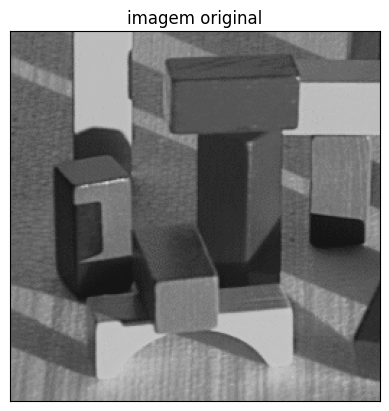

(256, 256)


In [107]:
%matplotlib inline

input_file = "blocks.pgm"
img = cv2.imread(input_file, cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img, cmap='gray', clim=(0, 256))
plt.title('imagem original')
plt.xticks([])
plt.yticks([])
plt.show()
org_size = img.shape
print(org_size)


# Compressão


In [108]:
filled_img = fill_image(img, STEP) - 128

bitstring = str()
# primeiros 4 bytes para armazenar o tamanho original da imagem
bitstring += str(bin(org_size[0])[2:].zfill(16)) + \
    str(bin(org_size[1])[2:].zfill(16))

size = filled_img.shape

print(size, org_size)
print(bitstring)

(256, 256) (256, 256)
00000001000000000000000100000000


In [109]:

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

# Inicializa listas para armazenar os coeficientes DC e AC, assim como os valores de entropia.
DC_objects = []
AC_objects = []
entropy_values = []

# Itera sobre os blocos da imagem.
for y in range(0, size[0], STEP):
    for x in range(0, size[1], STEP):
        # Aplica a Transformada Discreta do Cosseno (DCT) no bloco.
        dct = get_dct(filled_img[y:y+STEP, x:x+STEP])
        # Armazena o coeficiente DC.
        DC = dct[0, 0]

        # Calcula a entropia do bloco de imagem.
        block_entropy = calc_entropy(filled_img[y:y+STEP, x:x+STEP])
        # Gera a matriz de quantização com base na entropia.
        QM = generate_quantization_matrix(
            float(block_entropy*QUALITY_FACTOR)).astype(float)
        # Realiza a quantização do bloco.
        coddct = np.divide(dct, QM).round()

        # Ordena os coeficientes AC em um padrão zigzag.
        zigzag = np.concatenate(
            [np.diagonal(coddct[::-1, :], i)[::(2*(i % 2)-1)]
            for i in range(1-coddct.shape[0], coddct.shape[0])])

        # Adiciona os valores calculados às respectivas listas.
        entropy_values.append(bin(block_entropy)[2:].zfill(3))
        DC_objects.append(np.round(DC))
        AC_objects.append(AC_encoding(zigzag))

# Adiciona os valores de entropia e AC à string de bits.
for e in entropy_values: bitstring += e
for a in AC_objects: bitstring += a

# Adiciona os coeficientes DC à string de bits.
bitstring += encode_dc_coefficients(DC_objects)

# Salva a string de bits em um arquivo binário.
encoded_file = open("compressed.bin", "wb")
save_bitstring(encoded_file, bitstring)
encoded_file.close()

In [110]:
encoded_file = open("compressed.bin", "rb")
bitstring = "".join(f"{n:08b}" for n in open("compressed.bin", "rb").read())
print(bitstring)

0000000100000000000000010000000001101101101110010000100100101010001101110010001101101101101101101110001101101101101001110001001101101101101101110001000100101010101101101001101110001101101101101101101110010001101001110001001110010010001101110001000101001010101101110010010001101101101101101101101010001101110001110001110010001110010010010000100100101010001110010101101101001001101101101101101110001101001101001001001001110010001101110000100100101010001101110010001110001101101101101101101001110010001101110010010001101101110010010100100100101010101101110001000100100100100100100100100101001101001001001001001001101101101101110000100101000110101101110001000100100100100101000100100101101001001001001001001001101101101101110001001000100110001110010101100100100100100100100100100101101001001001001001001001101101101001110010010010010010010010010010001101101101101101101101010010001001101001101001001101101101101101101101001001001110101101110010001110001001001010010001010001101110001101101110010001101101

#Descompressão


In [111]:
#recupera as dimensões da imagem
header_size = [int(bitstring[0:16], 2), int(bitstring[16:32], 2)]
bitstring = bitstring[32:]

#torna as dimensoes da imagem multiplas do step
reconstructed_size = [header_size[0], header_size[1]]
if reconstructed_size[0] % STEP != 0:
    reconstructed_size[0] += STEP - (reconstructed_size[0] % STEP)
if reconstructed_size[1] % STEP != 0:
    reconstructed_size[1] += STEP - (reconstructed_size[1] % STEP)

block_count = int((reconstructed_size[0] * reconstructed_size[1]) / (STEP * STEP))

#recupera a entropia dos blocos
entropy_values = []
for i in range(0, block_count*3, 3):
    entropy_values.append(int(bitstring[i:i+3], 2))
bitstring = bitstring[block_count*3:]


In [112]:
aux = ""
pos = 0
rle = []

while (pos < len(bitstring) and block_count > 0):

    aux += bitstring[pos]

    # enquanto nao encontrar o fim de bloco
    if (aux != "1010"):

        # se encontrar um codigo na tabela dos AC
        if aux in AC_ILUMINANCE_TABLE['Code'].values:

            tupla = str(
            AC_ILUMINANCE_TABLE.index[AC_ILUMINANCE_TABLE["Code"] == aux][0])
            tupla = string_to_tuple(tupla)

            temp = pos+1
            number = bitstring[temp:(temp+tupla[1])]

            number = entropy_decoding_number(number)

            # adicionando ao vetor com rle encoding
            rle.append((tupla[0], tupla[1], number))

            pos += int(tupla[1])

            aux = ""

    # fim do bloco
    else:
        block_count -= 1
        rle.append((0, 0))
        aux = ""

    pos += 1


In [113]:

i = pos  # posição inicial dada
aux = ""  # string para armazenar a sequência temporária de bits
predictive_lossless = []  # a lista que armazenará os valores descompactados

while (i < len(bitstring)):
    aux += bitstring[i]

    # Verifica se a string temporária corresponde a algum código na tabela de Huffman
    if (aux in DC_ILUMINANCE_TABLE['Code'].values):
        # Se o código for '00', equivale a um valor zero na sequência descompactada
        if aux == '00':
            predictive_lossless.append(0)
        else:
            # Se não for '00', verifica o número de dígitos que o valor deve ter
            num_size = int(DC_ILUMINANCE_TABLE.index[DC_ILUMINANCE_TABLE["Code"] == aux][0])

            # Busca o próximo número compactado na string de bits
            temp = i+1
            number = bitstring[temp:(temp + num_size)]

            # Converte o valor binário para decimal
            number = entropy_decoding_number(number)

            # Adiciona o valor na lista descompactada
            predictive_lossless.append(number)

            # Avança o contador para depois do número que acabamos de descompactar
            i += num_size

        # Limpa a string temporária para poder encontrar o próximo código
        aux = ""

    # Avança o contador para o próximo bit para continuar a descompressão
    i += 1

j = 1

# Recupera os valores do coeficiente DC por meio do processo reverso da compressão sem perdas
while j < len(predictive_lossless):
    predictive_lossless[j] = predictive_lossless[j] + predictive_lossless[j-1]
    j += 1

In [114]:
reconstructed_img = np.zeros(shape=reconstructed_size)
reconstructed_img = fill_image(reconstructed_img, STEP)

aux_list = []
x = 0
y = 0
counter = 0

for tup in rle:
    aux_list.append(tup)
    QM = generate_quantization_matrix(float(entropy_values[counter]*QUALITY_FACTOR))
    if (tup == (0, 0)):
        # Transformando o rle do bloco em array
        rle_array = rle_to_array(aux_list)

        # Transformando o array em uma matriz ordenando em zigzag
        aux_matrix = zigzag_to_matrix(rle_array)

        # Multiplica a matriz pela matriz QM padrão
        aux_matrix = np.multiply(aux_matrix, QM)

        # Substituindo o primeiro elemento pelo DC
        aux_matrix[0, 0] = predictive_lossless[counter]

        # Fazendo a transformada inversa do cosseno
        aux_matrix = get_idct(aux_matrix)

        # Atribuindo a nova imagem
        reconstructed_img[y:y+STEP, x:x+STEP] = aux_matrix

        if (x == reconstructed_img.shape[1] - STEP & y == reconstructed_img.shape[0] - STEP):
            break

        x += STEP

        if (x == reconstructed_img.shape[1]):
            y += STEP
            x = 0

        aux_list = []
        counter += 1

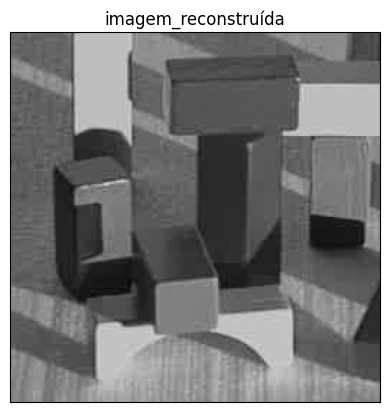

RMSE: 5.451
PSNR: 33.401
Taxa de Compressão: 13.003


In [115]:
reconstructed_img = reconstructed_img[:header_size[0], :header_size[1]] + 128

plt.imshow(reconstructed_img, cmap='gray', clim=(0, 255))
plt.title('imagem_reconstruída')
plt.xticks([])
plt.yticks([])
plt.show()

print("RMSE: %5.3f" % rmse(img, reconstructed_img))
print("PSNR: %5.3f" % psnr(img, reconstructed_img))

original_image_size = img.shape[0] * img.shape[1]
encoded_file_size = os.path.getsize("compressed.bin")

print("Taxa de Compressão: %5.3f" %
      (original_image_size/encoded_file_size))